In [1]:
# Load the required modules and add some workers

using Distributed
addprocs(2)
@everywhere using Springsteel
@everywhere using Scythe
@everywhere using DistributedData
@everywhere using SharedArrays
@everywhere using SparseArrays
using CairoMakie
using CSV
using DataFrames

Precompiling Scythe
  ✓ Scythe
  1 dependency successfully precompiled in 3 seconds. 296 already precompiled.


In [2]:
# Define the model parameters and grid
# This test uses a simple 1D Linear advection equation on the "R" grid
# The domain is 100 m long, is periodic, and the advection speed is 1 m/s
# The model will be run for 100 seconds, so the initial condition will be advected
# around and return to its initial position

model = ModelParameters(
    ts = 0.05,
    integration_time = 100.0,
    output_interval = 50.0,
    equation_set = "LinearAdvection1D",
    initial_conditions = "1d_linear_advection_test_ics.csv",
    output_dir = "./linear_advection_test/",
    grid_params = GridParameters(
        geometry = "R",
        xmin = -50.0,
        xmax = 50.0,
        num_cells = 100,
        BCL = Dict(
            "u" => CubicBSpline.PERIODIC),
        BCR = Dict(
            "u" => CubicBSpline.PERIODIC),
        vars = Dict(
            "u" => 1)),
    physical_params = Dict(
        :c_0 => 1.0,
        :K => 0.0))

ModelParameters(0.05, 100.0, 50.0, "LinearAdvection1D", "1d_linear_advection_test_ics.csv", "./linear_advection_test/", "", false, GridParameters("R", -50.0, 50.0, 100, 300, 103, 2.0, Dict("u" => Dict("PERIODIC" => 0)), Dict("u" => Dict("PERIODIC" => 0)), 0, 0, 0.0, 0.0, 0, 0, Dict("R0" => 0), Dict("R0" => 0), Dict("u" => 1), 1, 103, 0, 300, 0), Dict(:c_0 => 1.0, :K => 0.0))

In [3]:
# Create the grid object and get the gridpoints

scythegrid = Scythe.createGrid(model.grid_params)
gridpoints = Scythe.getGridpoints(scythegrid)

300-element Vector{Float64}:
 -49.887298334620745
 -49.5
 -49.112701665379255
 -48.887298334620745
 -48.5
 -48.112701665379255
 -47.887298334620745
 -47.5
 -47.112701665379255
 -46.887298334620745
 -46.5
 -46.112701665379255
 -45.887298334620745
   ⋮
  46.112701665379255
  46.5
  46.887298334620745
  47.112701665379255
  47.5
  47.887298334620745
  48.112701665379255
  48.5
  48.887298334620745
  49.112701665379255
  49.5
  49.887298334620745

In [4]:
# Fill the grid with a simple Gaussian curve

sigma = 20.0
for i = 1:scythegrid.params.rDim
    x = gridpoints[i]
    u = exp(-(x / sigma)^2)
    scythegrid.physical[i,1,1] = u
end

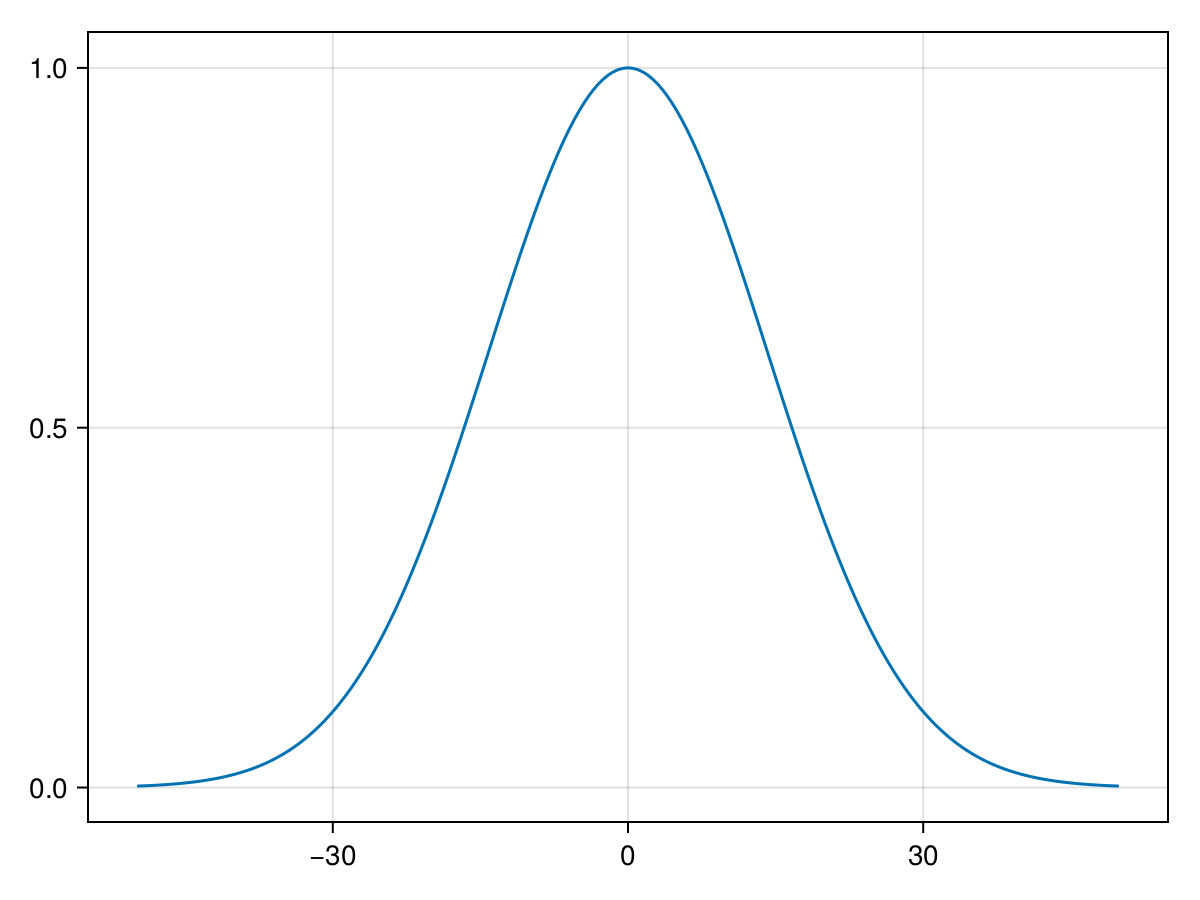

In [5]:
# Plot the initial conditions

lines(gridpoints[:],scythegrid.physical[:,1,1], label = "0 hr")

In [6]:
# Save the initial conditions to a CSV file

ics = DataFrame(r=gridpoints[:,1],
    u=scythegrid.physical[:,1,1]) 
CSV.write("1d_linear_advection_test_ics.csv",ics)

"1d_linear_advection_test_ics.csv"

In [7]:
# Run the model

@time integrate_model(model)

Starting model...
All done!
 15.863637 seconds (722.09 k allocations: 50.276 MiB, 0.07% gc time, 1.84% compilation time)


In [8]:
# Read in the initial conditions after conversion to the grid and final results

initial = CSV.read("./linear_advection_test/physical_out_0.0.csv", DataFrame, header=1)
final = CSV.read("./linear_advection_test/physical_out_100.0.csv", DataFrame, header=1)
radius = initial.r
u0 = initial.u
u500 = final.u

300-element Vector{Float64}:
 0.002313123964781471
 0.002360519054993529
 0.00246349122487367
 0.002548395919157989
 0.0027355878549166985
 0.002972249990784942
 0.003131486613105609
 0.0034398999068786552
 0.00378966742591355
 0.004011054731328816
 0.004420618372811611
 0.004865981948719798
 0.0051411836753819115
 ⋮
 0.004863505139382702
 0.004414163775348762
 0.004000924945663771
 0.0037777084519054925
 0.003425562571575936
 0.003115955094094483
 0.002956666400324165
 0.0027210585276626295
 0.002536253033488138
 0.0024532952480020914
 0.00235442836808728
 0.0023117167422260438

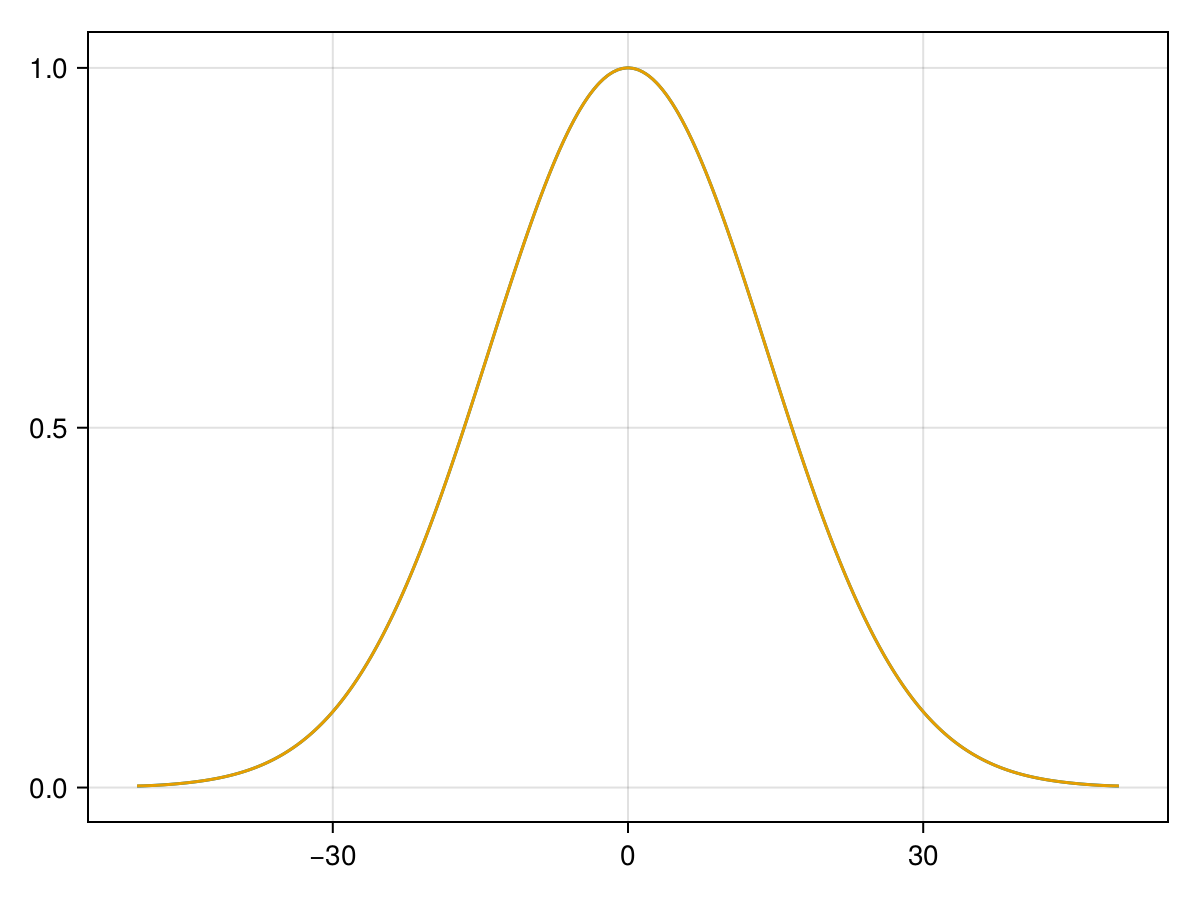

In [9]:
# Plot the initial and final results, which should be identical

lines(initial.r,initial.u, label = "0 secs")
lines!(final.r,final.u, label = "100 secs")
current_figure()

In [10]:
# Calculate the RMS difference between the initial and final result
# Correct answer should be small

l2_norm = sqrt(sum((initial.u .- final.u).^2))

0.0006515774105549754

In [ ]:
rmprocs(2)